In [703]:
import geopandas as gpd
import networkx as nx
import numpy as np
from libpysal import weights
import matplotlib.pyplot as plt
import momepy
from shapely.geometry import Polygon, Point, LineString
from copy import deepcopy
import json
from collections import deque

In [704]:
def convert_polygons_to_centroids(gdf):
    gdf["polygons"] = gdf['geometry']
    gdf['geometry'] = gdf.geometry.centroid
    return gdf

In [705]:
def filter_points_based_on_specified_region(gdf, region):
    gdf = gdf[gdf.geometry.within(region)]
    return gdf

In [706]:
def convert_geojsons_with_lines_to_graph(gdf):
    G = momepy.gdf_to_nx(gdf, approach="primal")
    G.graph['metadata'] = gdf.to_dict(orient='records')
    '''
    positions = {n: [n[0], n[1]] for n in list(G.nodes)}
    f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    gdf.plot(color="k", ax=ax[0])
    for i, facet in enumerate(ax):
        facet.set_title(("Улицы", "Graph")[i])
        facet.axis("off")
    nx.draw(G, positions, ax=ax[1], node_size=5)
    '''
    return G

In [707]:
def convert_geojsons_with_polygons_and_points_to_graph(gdf):
    coordinates = coordinates = np.column_stack((gdf.geometry.x, gdf.geometry.y))
    graph_init = weights.DistanceBand.from_array(coordinates, threshold=0.001)
    #graph_init = weights.KNN.from_dataframe(gdf, k=2)
    graph = graph_init.to_networkx()
    '''
    positions = dict(zip(graph.nodes, coordinates))
    f, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    if "polygons" in gdf:
        gdf["polygons"].plot(color="k", ax=ax[0])
    else:
        gdf.plot(color="k", ax=ax[0])
    for i, facet in enumerate(ax):
        facet.set_title(("Строения/остановки", "Graph")[i])
        facet.axis("off")
    nx.draw(graph, positions, ax=ax[1], node_size=5)
    plt.show()
    '''
    return graph

In [708]:
def add_new_nodes_to_graph(source_graph, current_graph, list_with_new_gdf):
    for new_gdf in list_with_new_gdf:
        for _, row in new_gdf.iterrows():
            new_coord = (row.geometry.x, row.geometry.y)
            current_graph.add_node(new_coord)

            distances = [Point(new_coord).distance(Point(existing_coord)) for existing_coord in list(source_graph.nodes)]
            min_index = distances.index(min(distances))
            closest_node_id = list(source_graph.nodes)[min_index]
            current_graph.add_edge(new_coord, closest_node_id, weight=distances[min_index])
            current_graph.graph['metadata'].append(row.to_dict())

    return current_graph

In [709]:
def visualise_final_graph(graph, objects_info):
    positions = {n: [n[0], n[1]] for n in list(graph.nodes)}
    
    _, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    for key, gdf_list in objects_info.items():
        if key == "polygons":
            gdf_list[0]["polygons"].plot(color="k", ax=ax[0])
        else:
            for gdf in gdf_list:
                if not gdf.empty:
                    gdf.plot(color="k", ax=ax[0])

    for i, facet in enumerate(ax):
        facet.set_title(("Дороги/Улицы/Здания", "Граф со всеми данными")[i])
        facet.axis("off")
    nx.draw(graph, positions, ax=ax[1], node_size=5)
    plt.show()

In [710]:
def get_graph_on_first_iteration(geojsons_with_points, 
                                 geojson_with_lines, 
                                 geojson_with_polygons,
                                 region):
    objects_info = {"polygons": [], "points": [], "lines": []}

    # Обработали остановки и станции метро
    for file in geojsons_with_points:
        gdf = gpd.read_file(f"./data/vector_data/{file}") 
        gdf["geometry"] = gdf["geometry"].to_crs("EPSG:4326")
        # Оставили точки из нужного региона
        gdf = filter_points_based_on_specified_region(gdf, region)
        objects_info["points"].append(gdf) 

    # Обработали здания
    gdf = gpd.read_file(f"./data/vector_data/{geojson_with_polygons}") 
    gdf["geometry"] = gdf["geometry"].to_crs("EPSG:4326")
    gdf = convert_polygons_to_centroids(gdf)
    gdf = filter_points_based_on_specified_region(gdf, region)
    objects_info["polygons"].append(gdf)   

    # Обработали дороги
    gdf = gpd.read_file(f"./data/vector_data/{geojson_with_lines}") 
    gdf["geometry"] = gdf["geometry"].to_crs("EPSG:4326")
    gdf = filter_points_based_on_specified_region(gdf, region)
    road_graph = convert_geojsons_with_lines_to_graph(gdf)
    objects_info["lines"].append(gdf)

    # Делаем копию дорожного графа
    road_graph_copy = deepcopy(road_graph)
    # Присоединяем к дорогам здания
    road_graph = add_new_nodes_to_graph(road_graph_copy, road_graph, objects_info["polygons"])
    # Присоединяем к дорогам станции метро/остановки
    road_graph = add_new_nodes_to_graph(road_graph_copy, road_graph, objects_info["points"])
    # Визуализируем финальный граф
    visualise_final_graph(road_graph, objects_info)

    return road_graph

In [711]:
geojsons_with_polygons = ["Дома_исходные.geojson"]#, "House_1очередь_ЖК.geojson", "House_2очередь_ЖК.geojson", "House_3очередь_ЖК.geojson"]
geojsons_with_lines = ["Streets_исходные.geojson"]#, "Streets_1очередь.geojson", "Streets_2очередь.geojson", "Streets_3очередь.geojson"]
geojsons_with_points = ["Остановки_ОТ.geojson", "Выходы_метро.geojson"]
# Обозначим границы региона
x_min, y_max = 37.472381, 55.551288 
x_max, y_min = 37.500082, 55.539195
region = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])

In [712]:
def update_graph_data(instance):
    # сохраним данные слоя
    if isinstance(instance, Point):
        return (instance.x, instance.y)
    elif isinstance(instance, LineString):
        return [(x, y) for x, y in instance.coords]
    elif isinstance(instance, Polygon):
        exterior = [(x, y) for x, y in instance.exterior.coords]
        interiors = [[(x, y) for x, y in ring.coords] for ring in instance.interiors]
        return {
            'exterior': exterior,
            'interiors': interiors
        }

C:\Users\trans\AppData\Local\Temp\ipykernel_30552\1442734587.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['geometry'] = gdf.geometry.centroid
d:\vscode\Kaliningrad_hack_2024\AI_working_tool_for_urban_development_data\env\Lib\site-packages\momepy\utils.py:352: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_network[length] = gdf_network.geometry.length


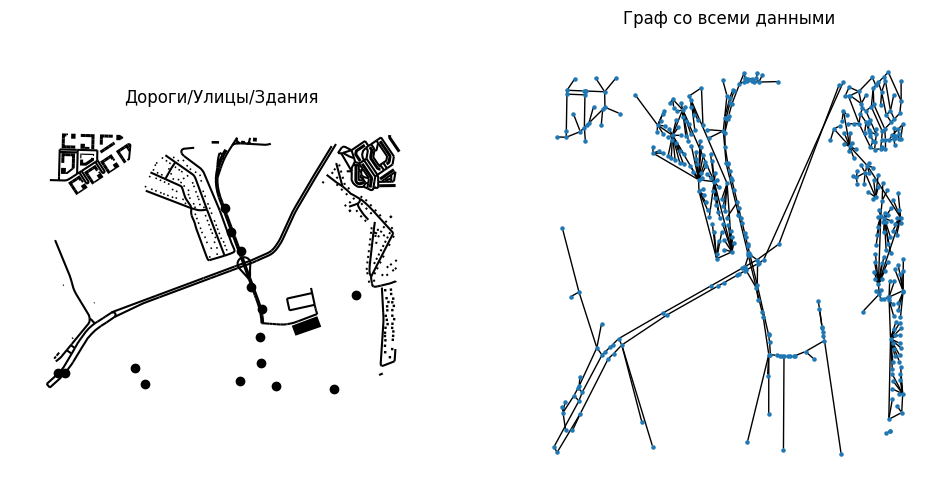

[{'EdgeId': 19032, 'ST_NAME': '1-я', 'ST_TYP_BEF': 'улица', 'ST_NM_BASE': '1-я', 'ST_NM_CITY': '', 'FUNC_CLASS': 6, 'ROAD_CATEG': 'Внутриквартальные проезды', 'F_ZLEV': 0, 'T_ZLEV': 0, 'TYPE_LINK': 'Обычное звено', 'RoadDirect': 'Any', 'RbndStght': 1.0, 'RbndBck': 1.0, 'Width': 6.0, 'IsFerry': 'F', 'Style': 0, 'U_TURN': 3, 'OriginId': '4504316886927960', 'TrackNames': '', 'TopoNames1': '', 'MaxSpdDrct': 20, 'AvgSpdDrct': 20, 'MaxSpdRvrs': 20, 'AvgSpdRvrs': 20, 'Foot': 1, 'Car': 1, 'duplicat': '', 'payment': '', 'material': '', 'length': 265.715, 'geometry': [(37.4989270095748, 55.54104978215911), (37.498874278467625, 55.54108922473254), (37.498862330874346, 55.541150116668966), (37.499080441825335, 55.54302943536421), (37.49908080115145, 55.54323695543432), (37.49906409248716, 55.54342170480771)]}, {'EdgeId': 19223, 'ST_NAME': '1-я', 'ST_TYP_BEF': 'улица', 'ST_NM_BASE': '1-я', 'ST_NM_CITY': '', 'FUNC_CLASS': 6, 'ROAD_CATEG': 'Внутриквартальные проезды', 'F_ZLEV': 0, 'T_ZLEV': 0, 'TYPE_

In [713]:
graph = get_graph_on_first_iteration(geojsons_with_points,
                             "Streets_исходные.geojson",
                             "Дома_исходные.geojson",
                             region)

for instance in graph.graph['metadata']:
    instance['geometry'] = update_graph_data(instance["geometry"])
    if "polygons" in instance:
        instance['polygons'] = update_graph_data(instance["polygons"])

print(graph.graph['metadata'])
with open("layer_info.json", "w", encoding="utf-8") as final:
    json.dump({"layer_info": graph.graph['metadata']}, final)

In [714]:
def visualise_source_graph_and_quadratic_grid(graph, grid):
    positions = {n: [n[0], n[1]] for n in list(graph.nodes)}
    pos = {(x, y): (x, -y) for (x, y) in grid.nodes()}  # Flip y-axis for better visualization
    _, ax = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)
    for i, facet in enumerate(ax):
        facet.set_title(("Граф со всеми данными", "Квадратная сетка")[i])
        facet.axis("off")
    nx.draw(graph, positions, ax=ax[0], node_size=5)
    nx.draw(grid, pos, ax=ax[1], node_size=5, with_labels=True)
    plt.show()

In [715]:
def find_best_position(used_positions, grid_size):
    for y in range(grid_size):
        for x in range(grid_size):
            pos = (x, y)
            if pos not in used_positions:
                used_positions.add(pos)
                return pos
    return None

def convert_graph_to_quadratic_grid1(graph):
    # Считаем количество узлов в исходном графе
    num_nodes = len(graph.nodes)
    # Считаем размер сетки
    grid_size = int(np.ceil(np.sqrt(num_nodes)))
    # Создаем сетку
    grid = nx.grid_2d_graph(grid_size, grid_size)
    # Проверяем, что в сетке не меньше узлов чем в исходном графе
    if num_nodes > len(grid.nodes):
        raise ValueError("В графе больше узлов чем в сетке!")
    
    # Заменяем узлы
    sorted_nodes = sorted(graph.nodes, key=lambda x: graph.degree(x), reverse=True)
    node_mapping = {}
    used_positions = set()
    for node in sorted_nodes:
        pos = find_best_position(used_positions, grid_size)
        if pos:
            node_mapping[node] = pos

    # Добавляем соединения
    for u, v, data in graph.edges(data=True):
        if u in node_mapping and v in node_mapping:
            grid.add_edge(node_mapping[u], node_mapping[v], **data)

    return grid

In [716]:
quadratic_grid = convert_graph_to_quadratic_grid1(graph)
#visualise_source_graph_and_quadratic_grid(graph, quadratic_grid)

In [717]:
def snap_to_grid(pos, grid_size):
    snapped_pos = {}
    for node, (x, y) in pos.items():
        grid_x = round(x * grid_size)
        grid_y = round(y * grid_size)
        snapped_pos[node] = (grid_x, grid_y)
    return snapped_pos

def convert_graph_to_quadratic_grid2(graph):
    # Проверяем, планарный ли граф
    is_planar, _ = nx.check_planarity(graph)
    # Считаем количество узлов в исходном графе
    num_nodes = len(graph.nodes)
    # Считаем размер сетки
    grid_size = int(np.ceil(np.sqrt(num_nodes)))
    # Если граф планарный то обрабатываем по-другому
    if is_planar:
        planar_layout = nx.planar_layout(graph)
        snapped_pos = snap_to_grid(planar_layout, grid_size)
        nx.draw(graph, pos=snapped_pos, node_color='lightgreen', edge_color='gray')
        plt.show()
    else:
        pos = nx.spring_layout(graph, seed=42)
        snapped_pos = snap_to_grid(pos, grid_size)
        nx.draw(graph, pos=snapped_pos, node_color='lightblue', edge_color='gray')
        plt.show()

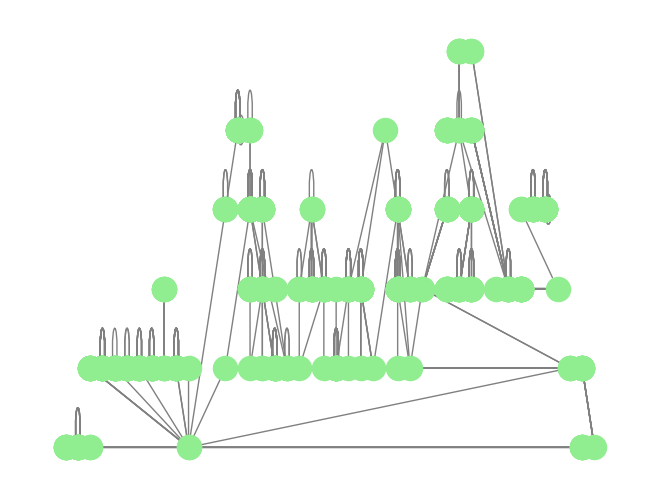

In [718]:
quadratic_grid = convert_graph_to_quadratic_grid2(graph)